In [ ]:
"""
Refine topic modeling

- Model: NMF (Tf-idf)
- Data: divide all transcripts into subgroups
- Goal: see the evolution of topic trends

"""

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import Counter

from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

from wordcloud import WordCloud

from gensim import matutils, models
import scipy.sparse

import re
import string

import nltk
from nltk import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline


%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/katiehuang/Documents/metis/projects/onl_ds5_project_4/py')
from word_cloud import *
from clean import *
import importlib

In [3]:
# Let's read in our transcripts and document-term matrix
speech_df_raw = pd.read_pickle('../dump/speech_df')
speech_df = pd.read_pickle('../dump/speech_clean_lemma')
speech_concise = pd.read_pickle('../dump/speech_concise')
# data = pd.read_pickle('../dump/data_dtm_lemma.pkl')
# tdm = data.transpose()
# tdm.shape

## 1. Divide the transcripts base on time
Aim to divied into 5 parts; each ~ 90 speeches.
1. Pre 2003
2. 2003-2009
3. 2009-2012
4. 2012-2015
5. 2015-

In [4]:
# Examine years
sorted_year = speech_df.sort_values('year')
sorted_year

,speaker,year,transcript,length
440,GARRISON KEILLOR,0,its an honor to be with so many smart people a...,8063
439,RALPH WALDO,1838,in this refulgent summer it have be a luxury t...,40403
438,OPRAH WINFREY,1918,thank you wallis annenberg and a special thank...,15301
437,FRANKLIN D ROOSEVELT,1932,for me as for you this be a day of honorable a...,16017
436,CARRIE CHAPMAN,1936,i bring a message to sweet briar college and e...,22942
...,...,...,...,...
4,JESMYN WARD,2018,persist be patient be well good morning it be ...,14063
3,MINDY KALING,2018,good morning to the class of the faculty the p...,15391
2,JON B. FISHER,2018,thank you very much my father commencement spe...,8544
1,ABBY WAMBACK,2018,failure be not something to be ashamed of its ...,15866


In [5]:
# Update correct year
sorted_year.loc[440,'year'] = 2015
sorted_year = sorted_year.sort_values('year')

In [6]:
# Count number of speech in each time slot
speech_df_1 = sorted_year[sorted_year.year<2003]
speech_df_2 = sorted_year[(sorted_year.year>= 2003)&(sorted_year.year<2009)]
speech_df_3 = sorted_year[(sorted_year.year>= 2009)&(sorted_year.year<2012)]
speech_df_4 = sorted_year[(sorted_year.year>= 2012)&(sorted_year.year<2015)]
speech_df_5 = sorted_year[sorted_year.year>= 2015]

speech_df_1.shape[0],\
speech_df_2.shape[0],\
speech_df_3.shape[0],\
speech_df_4.shape[0],\
speech_df_5.shape[0],

(87, 90, 94, 101, 69)

## 2. Preparation for topic modeling

In [7]:
def topic_modeling(speech_df_x,column_name,num_topic):
    """
    For a given df and column_name (e.g.:'transcript' for all text, 'nouns' for nouns only),
    return the topic_word dataframe
    
    Method: Tf-idf and NMF
    
    """
    
    # Prepare Tf-idf
    tfidf = TfidfVectorizer()
    csr_mat = tfidf.fit_transform(speech_df_x[column_name])
    doc_word = tfidf_dtm(speech_df_x,column_name)

    # Modeling
    nmf_model = NMF(num_topic, max_iter=1000)
    doc_topic = nmf_model.fit_transform(doc_word)
    doc_assigned_topic = doc_topic.argsort(axis=1)[:,-1]

    # Use components in NMF model to find the top 10 words for a given topic
    topics = nmf_model.components_.argsort(axis=1)[:,-1:-11:-1]

    # Create topic_worrd df
    words = doc_word.columns
    topic_words = [[words[index] for index in topic] for topic in topics]
    topic_word_df = pd.DataFrame(topic_words,index=['Topic #' + '{:02d}'.format(i+1) for i in range(num_topic)])
    
    return topic_word_df

In [80]:
# First use the topic model on all transcripts

num_topic = 8
speech_df_x = wash(speech_concise,'transcript').copy()
topic_df = topic_modeling(speech_df_x,'nouns',num_topic)
topic_df

,0,1,2,3,4,5,6,7,8,9
Topic #01,parent,advice,film,story,money,friends,kid,person,movie,play
Topic #02,women,workers,voice,genius,floor,success,conversation,mother,workforce,skirt
Topic #03,generation,country,government,community,education,history,nation,nations,century,freedom
Topic #04,dream,education,mother,father,degree,family,thank,sister,community,value
Topic #05,fear,generosity,hearts,drum,heart,truth,moment,mind,practice,death
Topic #06,team,tennis,sport,game,player,coach,baseball,dream,soccer,percent
Topic #07,art,science,book,paint,artist,shell,scientist,course,botany,seashells
Topic #08,company,business,journey,career,passion,technology,selfconfidence,leadership,confidence,engineer


In [82]:
# Find assigned_topic

tfidf = TfidfVectorizer()
csr_mat = tfidf.fit_transform(speech_df_x['nouns'])
doc_word = tfidf_dtm(speech_df_x,'nouns')

# Modeling
nmf_model = NMF(num_topic, max_iter=1000)
doc_topic = nmf_model.fit_transform(doc_word)

# Array of assigned topic
doc_assigned_topic = doc_topic.argsort(axis=1)[:,-1]+1

In [83]:
# Create column for topic
speech_df_x['topic'] = doc_assigned_topic

In [84]:
speech_df_x.head()

,speaker,year,school,transcript,transcript_clean,category,age,age_then,age_cat,region,nouns,topic
0,CARLY FIORINA,2000,MIT,like to start my remark this morning with spec...,I'd start remarks morning special thanks sent ...,Tech/Business,66,46,40-50,east,remark morning thank couple weeks speech comme...,4
1,J.K. ROWLING,2008,Harvard University,i have wrack my mind and heart for what i ough...,"EXCERPTS Actually, I wracked mind heart I ough...",Publish,55,43,40-50,east,i mind heart i today i i graduation lessons ye...,5
2,JEAN ANDREWS,2003,University of Texas at Austin,when invite me to present the commencement add...,\nWhen Dean Rankin invited present commencemen...,Education/Research,97,80,80-90,central,commencement address class graduate i anyone y...,7
3,MIKE TOMLIN,2008,Saint Vincent College,some excerpt as find in want to encourage you ...,"Some excerpts Post Gazette:\n\n ""I encourag...",Sport,48,36,30-40,east,excerpt find want preparation game life minute...,6
4,AARON SORKIN,2012,SYRACUSE UNIVERSITY,you very much members of the of members of the...,"Thank much. Madam Chancellor, members Board T...",Publish,59,51,50-60,east,members members faculty administration parent ...,1


In [12]:
# # Pickle
# speech_df_x.to_pickle('../dump/speech_topic_NMF')

In [69]:
# speech_df_x.iloc[1].transcript

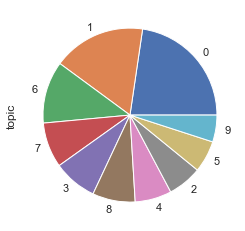

In [19]:
# 10
# Check topic distribution over time
dist_df = speech_df_x.topic.value_counts()
dist_df.plot.pie(y='topic');

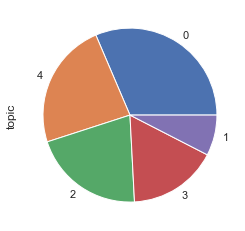

In [39]:
# 5 with speech_concise
# Check topic distribution over time
dist_df = speech_df_x.topic.value_counts()
dist_df.plot.pie(y='topic');

In [87]:
topic_year = []
for i in range(num_topic):
    topic_year.append(speech_df_x[speech_df_x.topic == i+1].sort_values('year').year.value_counts().sort_index())

In [123]:
topic_yeat_df = pd.DataFrame(topic_year,index=[i+1 for i in range(num_topic)]).fillna(0)
topic_yeat_df_T = topic_yeat_df.loc[:,2000:].transpose()
topic_yeat_df_T['9']=[0]*topic_yeat_df_T.shape[0]       # just for adjusting the colormap later
# topic_yeat_df_T

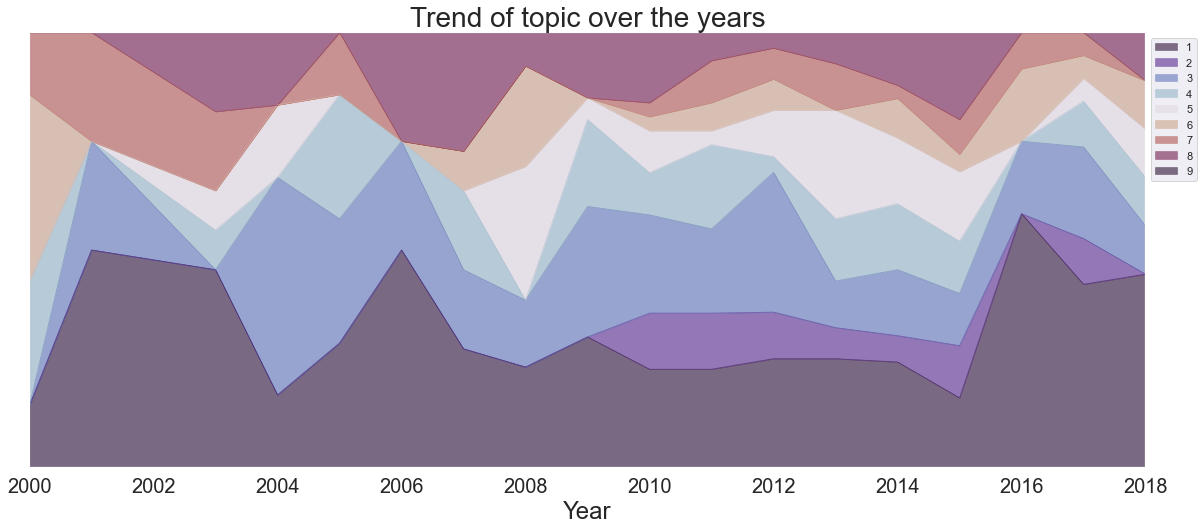

In [136]:
# Full stack area plot

plt.rcParams['figure.figsize']=[20,8]
cmap = plt.get_cmap('twilight_shifted')

df = topic_yeat_df_T.divide(topic_yeat_df_T.sum(axis=1), axis=0)
ax = df.plot(kind='area', stacked=True, alpha = 0.6, cmap = cmap,
             linewidth=0.5,
             title='100 % stacked area chart')


ax.set_ylabel('Percent (%)')
ax.margins(0, 0) # Set margins to avoid "whitespace"
plt.legend(bbox_to_anchor=(1., 1))
plt.ylim(0,1)
ax.grid(False)


ax.axes.yaxis.set_ticks([])
ax.set_title('Trend of topic over the years',fontsize=28)
ax.set_ylabel('',fontsize=18)
ax.set_xlabel('Year',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=14)

plt.show()

# 1. family, friends, advice
# 2. women's voice
# 3. nation, generation
# 4. dream, education
# 5. technology & challenge
# 6. sports
# 7. science & knowledge

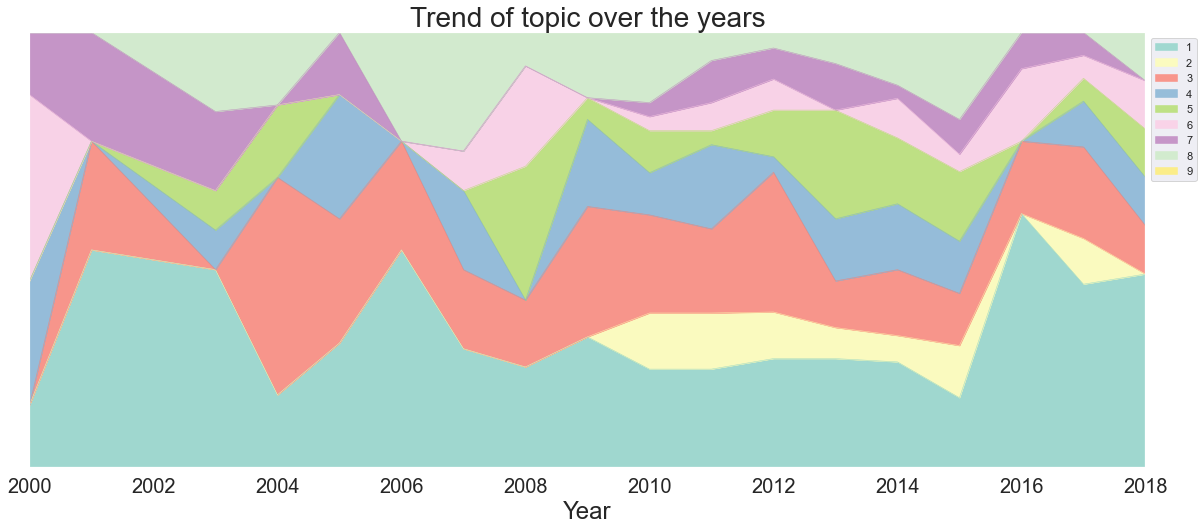

In [135]:
# Full stack area plot (just for trying out different colors)

plt.rcParams['figure.figsize']=[20,8]
cmap = plt.get_cmap('Set3')

df = topic_yeat_df_T.divide(topic_yeat_df_T.sum(axis=1), axis=0)
ax = df.plot(kind='area', stacked=True, alpha = 0.8, cmap = cmap,
             linewidth=0.5,
             title='100 % stacked area chart')


ax.set_ylabel('Percent (%)')
ax.margins(0, 0) # Set margins to avoid "whitespace"
plt.legend(bbox_to_anchor=(1, 1))
plt.ylim(0,1)
ax.grid(False)


ax.axes.yaxis.set_ticks([])
ax.set_title('Trend of topic over the years',fontsize=28)
ax.set_ylabel('',fontsize=18)
ax.set_xlabel('Year',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=14)

plt.show()

# 1. family, friends, advice
# 2. women's voice
# 3. nation, generation
# 4. dream, education
# 5. technology & challenge
# 6. sports
# 7. science & knowledge

## 3. Topic modeling for each time frame

In [111]:
num_topic = 4

### A. Pre 2003

In [112]:
first = speech_df_raw[speech_df_raw.year<2003].copy()

In [113]:
# Wash the transcripts!
speech_df_x = wash(first,'transcript').copy()

#### All text

In [114]:
# topic_modeling(speech_df_x,'transcript',6)

#### Nouns only

In [115]:
topic_df = topic_modeling(speech_df_x,'nouns',num_topic)
topic_df

In [116]:
# Pickle
topic_df.to_pickle('../dump/to_nx_topic_df_1')

### B. 2003-2009

In [117]:
second = speech_df_raw[(speech_df_raw.year>= 2003)&(speech_df_raw.year<2009)].copy()

In [118]:
# Wash the transcripts!
speech_df_x = wash(second,'transcript').copy()

#### All text

In [119]:
# topic_modeling(speech_df_x,'transcript',6)

#### Nouns only

In [120]:
topic_df = topic_modeling(speech_df_x,'nouns',num_topic)
topic_df

,0,1,2,3,4,5,6,7,8,9
Topic #01,education,degree,community,dream,family,mother,opportunity,sister,thank,doctor
Topic #02,game,doors,kid,ball,door,husband,neighborhood,coach,country,dream
Topic #03,fear,idea,parent,age,failure,mind,sense,word,experience,generation
Topic #04,company,selfconfidence,business,percent,confidence,rule,purpose,career,challenge,engineer


In [121]:
# Pickle
topic_df.to_pickle('../dump/to_nx_topic_df_2')

### C. 2009-2012

In [122]:
third = speech_df_raw[(speech_df_raw.year>= 2009)&(speech_df_raw.year<2012)].copy()

In [123]:
# Wash the transcripts!
speech_df_x = wash(third,'transcript').copy()

#### All text

In [124]:
# topic_modeling(speech_df_x,'transcript',6)

#### Nouns only

In [125]:
topic_df = topic_modeling(speech_df_x,'nouns',num_topic)
topic_df

,0,1,2,3,4,5,6,7,8,9
Topic #01,education,money,parent,dream,heart,business,future,value,place,company
Topic #02,women,genius,conversation,success,workforce,balance,voice,belong,worlds,girl
Topic #03,bird,dream,obstacles,drift,polluters,thuddy,compliance,grammar,instructors,bust
Topic #04,policy,grid,dream,commencement,mule,blue,diploma,man,address,months


In [126]:
# Pickle
topic_df.to_pickle('../dump/to_nx_topic_df_3')

### D. 2012-2015

In [127]:
fourth = speech_df_raw[(speech_df_raw.year>= 2012)&(speech_df_raw.year<2015)].copy()

In [128]:
# Wash the transcripts!
speech_df_x = wash(fourth,'transcript').copy()

#### All text

In [129]:
# topic_modeling(speech_df_x,'transcript',6)

#### Nouns only

In [130]:
topic_df = topic_modeling(speech_df_x,'nouns',num_topic)
topic_df

,0,1,2,3,4,5,6,7,8,9
Topic #01,dream,parent,fear,moment,story,year,friends,kid,family,room
Topic #02,advice,hater,voice,ignorance,women,silence,hiphop,book,marriage,pigeon
Topic #03,generation,women,success,country,place,challenge,education,history,family,children
Topic #04,substitute,phone,communication,someones,distract,dimension,entangle,responses,compassion,conversation


In [131]:
# Pickle
topic_df.to_pickle('../dump/to_nx_topic_df_4')

### E. 2015-

In [132]:
fifth = speech_df_raw[(speech_df_raw.year>= 2015)].copy()

In [133]:
# Wash the transcripts!
speech_df_x = wash(fifth,'transcript').copy()

#### All text

In [134]:
# topic_modeling(speech_df_x,'transcript',6)

#### Nouns only

In [135]:
topic_df = topic_modeling(speech_df_x,'nouns',num_topic)
topic_df

,0,1,2,3,4,5,6,7,8,9
Topic #01,advice,film,speech,voice,movie,play,career,money,letter,year
Topic #02,purpose,sense,generation,communities,freedom,company,project,society,community,millions
Topic #03,mother,shape,gender,women,prize,sign,feminism,makeup,privilege,earth
Topic #04,question,resilience,company,days,children,joy,step,family,cancer,success


In [136]:
# Pickle
topic_df.to_pickle('../dump/to_nx_topic_df_5')